In [1]:
from sentence_transformers import SentenceTransformer, util 
model = SentenceTransformer('stsb-xlm-r-multilingual') 
 
#Sentences are encoded by calling model.encode() 
emb1 = model.encode("今日は天気が悪いです") 
emb2 = model.encode("今日は雨です") 
 
cos_sim = util.cos_sim(emb1, emb2) 
print("コサイン類似度:", cos_sim)

コサイン類似度: tensor([[0.6703]])


In [2]:
import re
import mojimoji

def clean_text(text):
    text = mojimoji.han_to_zen(text, digit=False, ascii=False)
    text = mojimoji.zen_to_han(text, kana=False)
    text = text.lower()
    for s in ["(57)", "【要約】", "【課題】", "【解決手段】", "\r", "\n", "<br>", "（修正有）","【選択図】"]:
        text = re.sub(s, '', text)
    return text

In [3]:
import pandas as pd
# df_input = pd.read_csv('特実_国内文献_B60W4000_B60W5000_20210101-20230109.csv', encoding="utf-8")
df_input = pd.read_csv('data_JPlatPat/特実_国内文献.csv', encoding="utf-8")

In [4]:
df_input.dropna(subset=["要約"], inplace=True)

In [5]:
%%time
document_vecs=[]
for doc in df_input["要約"].values:
    document_vecs.append(model.encode(clean_text(doc)))

CPU times: total: 50min 9s
Wall time: 9min 35s


In [6]:
input_vec = model.encode("夜間と昼間で変更する")

#コサイン類似度の計算＋ランキング化
import numpy as np
rank_size = 10
 
v1 = np.linalg.norm(input_vec)
cos_sim = []
for v2 in document_vecs:
    cos_sim.append( np.dot(input_vec,v2)/(v1*np.linalg.norm(v2)) )
doc_sort = np.argsort(np.array(cos_sim))[::-1]
cos_sort = sorted(cos_sim,reverse=True)
 
for i in range(rank_size):
    print(cos_sort[i])
    print(df_input["出願人/権利者"].values[doc_sort[i]])
    print(df_input["FI"].values[doc_sort[i]])
    print(df_input["要約"].values[doc_sort[i]])
    

0.5605107
ホンダ　リサーチ　インスティテュート　ヨーロッパ　ゲーエムベーハー
G08G1/16@C,B60W50/14
(57)【要約】      （修正有）
【課題】人が動的環境を評価するのを補助する。
【解決手段】共通の環境内の少なくとも２つのエンティ<BR>ティの実際の状態についての情報が取得され、第１の将<BR>来状態が予測される。第１の事象に関する事象までの時<BR>間、位置、方向、蓋然性のうちの少なくとも１つが、予<BR>測される。更にエンティティのうちの少なくとも１つに<BR>関する第２の将来状態が予測される。仮定の状態は、実<BR>際の状態のパラメータを変更することによって生成され<BR>る。２つのエンティティを含む第２の事象に関する事象<BR>までの時間、方向、蓋然性、位置のうちの少なくとも１<BR>つが予測される。アクチュエータを駆動するための信号<BR>が生成される。信号は、第１の事象の位置、時間、蓋然<BR>性のうちの少なくとも１つをコード化する情報、第２の<BR>事象の位置、時間、方向、蓋然性のうちの少なくとも１<BR>つをコード化する更なる情報を示し、人がその認知能力<BR>によって認知可能な刺激を発する刺激作用を引き起こす<BR>。
【選択図】図７

0.5140334
株式会社東芝
B60W30/095,B60W40/04,B60W40/06,B60W50/14,B60W40/10,G08G1/16@C
(57)【要約】      （修正有）
【課題】移動体の未来の状態を少ない演算量で予測する<BR>。
【解決手段】予測装置４０は、レーン情報取得部５２と<BR>、推定部５６と、予測部５８とを備える。レーン情報取<BR>得部５２は、基準時刻より後において移動体が進行する<BR>可能性がある複数のレーンを表すレーン情報を取得する<BR>。推定部５６は、観測値およびレーン情報に基づき、複<BR>数のレーンに対する移動体の状態の時系列変化量および<BR>複数のレーンのそれぞれに対する移動体が進行する可能<BR>性を示す尤度情報を推定する。予測部５８は、尤度情報<BR>に基づき複数のレーンのうち１または複数の対象レーン<BR>を特定し、特定した対象レーンのそれぞれについて、基<BR>準時刻において取得された観測値に示される移動体の１<

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
%%time
FIs=[]
for FI in df_input["FI"].values:
    for s in FI.split(','):
        if(s[0].isdigit()):
            FIs.pop(-1)
            FIs.append(s_prev + "," + s)
            s_prev = ""
        else:
            FIs.append(s)
            s_prev = s

CPU times: total: 15.6 ms
Wall time: 18 ms


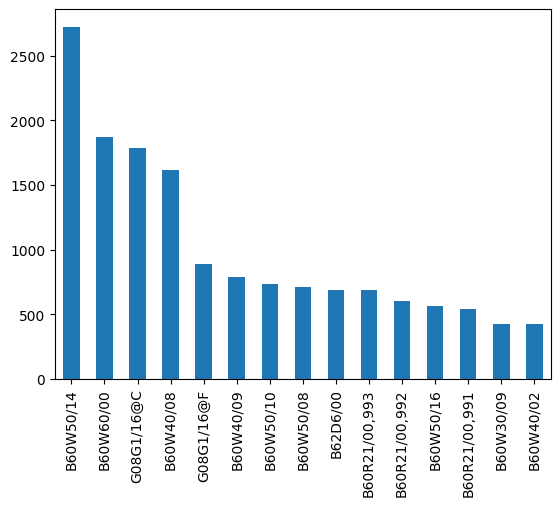

In [9]:
pd.Series(FIs).value_counts()[0:15].plot(kind='bar');

In [10]:
import pickle

def pickle_dump(obj, path):
    with open(path, mode='wb') as f:
        pickle.dump(obj,f)

def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data

In [11]:
df_input.to_pickle("df_input_default.pkl")

In [12]:
pickle_dump(document_vecs, './document_vecs_default.pkl')